In [1]:
%%HTML
<style>
    body {
        --vscode-font-family: "Roboto Thin"
    }
</style>

<center>
<h1> SuGaR: Surface-Aligned Gaussian Splatting for Efficient 3D Mesh Reconstruction 
    <br>and High-Quality Mesh Rendering</h1>
Antoine Guédon and Vincent Lepetit

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import (
    AmbientLights,
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    )
from pytorch3d.renderer.blending import BlendParams
from sugar_scene.gs_model import GaussianSplattingWrapper
from sugar_scene.sugar_model import SuGaR, load_refined_model
from sugar_utils.spherical_harmonics import SH2RGB

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Using original 3DGS rasterizer from Inria.


In [3]:
numGPU = 0
torch.cuda.set_device(numGPU)

# Load data and vanilla Gaussian Splatting

In [4]:
# ========== Loading parameters ==========
use_eval_split = False
n_skip_images_for_eval_split = 8

iteration_to_load = 7000
# iteration_to_load = 30_000

load_gt_images = False
use_custom_bbox = False

Choose a data directory (the directory that contains the images subdirectory).

In [5]:
# Example
source_path = './dataset/resized/'

Choose a corresponding vanilla Gaussian Splatting checkpoint directory.

In [6]:
# Example
gs_checkpoint_path = './output/vanilla_gs/resized/'

Load data and 3DGS checkpoint.

In [7]:
# ====================Load NeRF model and training data====================

# Load Gaussian Splatting checkpoint 
print(f"\nLoading config {gs_checkpoint_path}...")
if use_eval_split:
    print("Performing train/eval split...")
nerfmodel = GaussianSplattingWrapper(
    source_path=source_path,
    output_path=gs_checkpoint_path,
    iteration_to_load=iteration_to_load,
    load_gt_images=load_gt_images,
    eval_split=use_eval_split,
    eval_split_interval=n_skip_images_for_eval_split,
    )

print(f'{len(nerfmodel.training_cameras)} training images detected.')
print(f'The model has been trained for {iteration_to_load} steps.')
print(len(nerfmodel.gaussians._xyz) / 1e6, "M gaussians detected.")


Loading config ./output/vanilla_gs/resized/...
Found image extension .jpg
251 training images detected.
The model has been trained for 7000 steps.
1.230644 M gaussians detected.


# Render with a refined SuGaR model

Choose a corresponding refined SuGaR checkpoint directory (located in `refined/<your scene>`)

In [ ]:
coarse_sugar_folder = "./output/coarse/resized/sugarcoarse_3Dgs7000_const_1_supervised_sdfestim02_sdfnorm2"
# Change the iteration if needed (keeping same variable name for simplicity)
refined_iteration_to_load = 15_000  # or whatever iteration you want to use

# Change the path construction
coarse_sugar_path = os.path.join(coarse_sugar_folder, f"{refined_iteration_to_load}.pt")
print(f"\nLoading config {coarse_sugar_path}...")

# For coarse model, you typically use regular load function rather than load_refined_model
from sugar_scene.sugar_model import SuGaR
checkpoint = torch.load(coarse_sugar_path, map_location=nerfmodel.device, weights_only=False)

print(checkpoint['state_dict']['_points'].shape)
print(checkpoint['state_dict']['_sh_coordinates_dc'].shape)
# Create a new SuGaR instance
coarse_sugar = SuGaR(
    nerfmodel=nerfmodel,
    points=checkpoint['state_dict']['_points'],
    colors=SH2RGB(checkpoint['state_dict']['_sh_coordinates_dc'][:, 0, :]),
    initialize=False,
    sh_levels=4,  # Adjust based on your model
    learnable_positions=True,
    n_gaussians_per_surface_triangle=1,
    beta_mode='average',
    keep_track_of_knn=False,
    knn_to_track=0,
)
coarse_sugar.load_state_dict(checkpoint['state_dict'])



Loading config ./output/coarse/resized/sugarcoarse_3Dgs7000_const_1_supervised_sdfestim02_sdfnorm2/15000.pt...
torch.Size([259830, 3])
torch.Size([259830, 1, 3])


<All keys matched successfully>

Choose a refinement iteration to load.

Load the refined SuGaR checkpoint.

Render an image.

Rendering image with index 136.
Image name: 000137


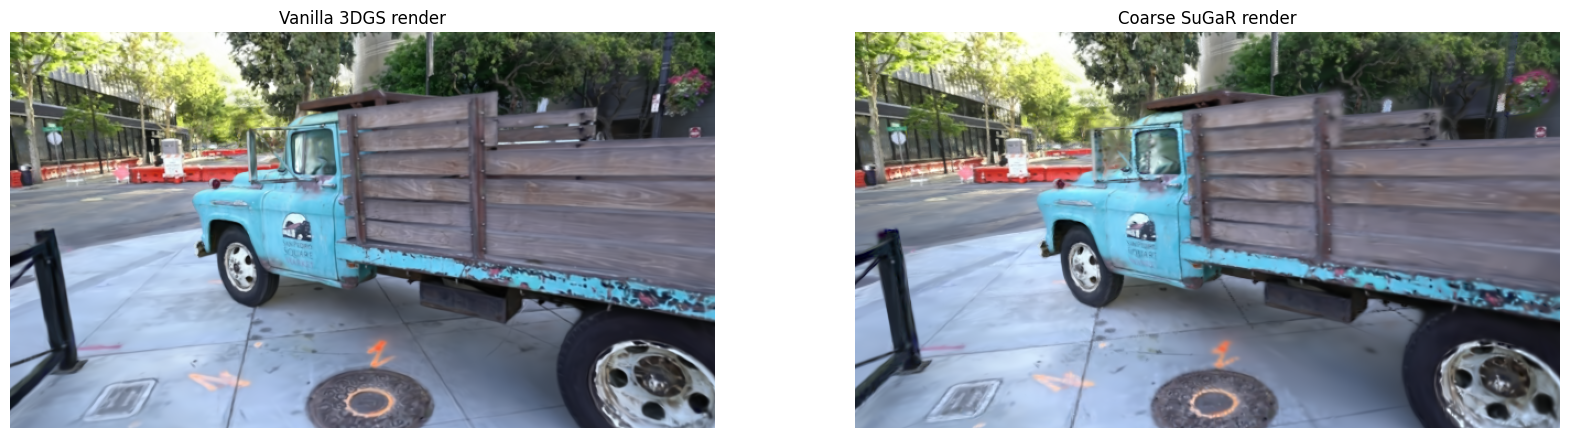

In [ ]:
onsamerow = True
also_render_vanilla_3dgs = True

# -----Camera to render-----
cameras_to_use = nerfmodel.training_cameras
# cameras_to_use = nerfmodel.test_cameras

cam_idx = np.random.randint(0, len(cameras_to_use.gs_cameras))

print(f"Rendering image with index {cam_idx}.")
print("Image name:", cameras_to_use.gs_cameras[cam_idx].image_name)
# --------------------------

# Replace refined_sugar with coarse_sugar in the rendering code
coarse_sugar.eval()
coarse_sugar.adapt_to_cameras(cameras_to_use)

# ...rest of code remains the same but using coarse_sugar instead of refined_sugar

with torch.no_grad():
    if also_render_vanilla_3dgs:
        gs_image = nerfmodel.render_image(
            nerf_cameras=cameras_to_use,
            camera_indices=cam_idx,
            #override_color=torch.tensor([0.2,0.1,0.4],device="cuda").unsqueeze(0).unsqueeze(0).expand(nerfmodel.gaussians.get_features.shape)
        ).clamp(min=0, max=1)
    
    sugar_image = coarse_sugar.render_image_gaussian_rasterizer(
        nerf_cameras=cameras_to_use, 
        camera_indices=cam_idx,
        sh_deg=nerfmodel.gaussians.active_sh_degree,
        compute_color_in_rasterizer=True,
    ).nan_to_num().clamp(min=0, max=1)

    

plot_ratio = 2. # 0.7, 1.5, 5

if also_render_vanilla_3dgs:
    fig, axes = plt.subplots(1, 2, figsize=(10 * plot_ratio, 5 * plot_ratio))
    axes[0].axis("off")
    axes[0].set_title("Vanilla 3DGS render")
    axes[0].imshow(gs_image.cpu().numpy())
    axes[1].axis("off")
    axes[1].set_title("Coarse SuGaR render")
    axes[1].imshow(sugar_image.cpu().numpy())
    plt.show()
else:
    plt.figure(figsize=(5 * plot_ratio, 5 * plot_ratio))
    plt.axis("off")
    plt.title("Coarse SuGaR render")
    plt.imshow(sugar_image.cpu().numpy())
    plt.show()
torch.cuda.empty_cache()